In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [2]:
# Load Breast Cancer dataset
data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

print("Dataset shape:", X.shape)
print("Target distribution:")
print(pd.Series(y).value_counts())


Dataset shape: (569, 30)
Target distribution:
1    357
0    212
dtype: int64


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [4]:
model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [5]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {acc:.4f}")


Model Accuracy: 0.9561


In [6]:
# Pick one instance for explanation later
sample_instance = X_test.iloc[0]
sample_instance


mean radius                  19.550000
mean texture                 28.770000
mean perimeter              133.600000
mean area                  1207.000000
mean smoothness               0.092600
mean compactness              0.206300
mean concavity                0.178400
mean concave points           0.114400
mean symmetry                 0.189300
mean fractal dimension        0.062320
radius error                  0.842600
texture error                 1.199000
perimeter error               7.158000
area error                  106.400000
smoothness error              0.006356
compactness error             0.047650
concavity error               0.038630
concave points error          0.015190
symmetry error                0.019360
fractal dimension error       0.005252
worst radius                 25.050000
worst texture                36.270000
worst perimeter             178.600000
worst area                 1926.000000
worst smoothness              0.128100
worst compactness        

In [7]:
from explain_my_model.explainer import Explainer

# Initialize explainer
explainer = Explainer(model, X_train)

# Global feature importance
global_importance = explainer.global_feature_importance()

global_importance


,feature,importance
27,worst concave points,0.067472
23,worst area,0.066901
20,worst radius,0.048642
22,worst perimeter,0.043781
7,mean concave points,0.041623
6,mean concavity,0.029406
2,mean perimeter,0.027528
0,mean radius,0.026218
26,worst concavity,0.024152
3,mean area,0.021800


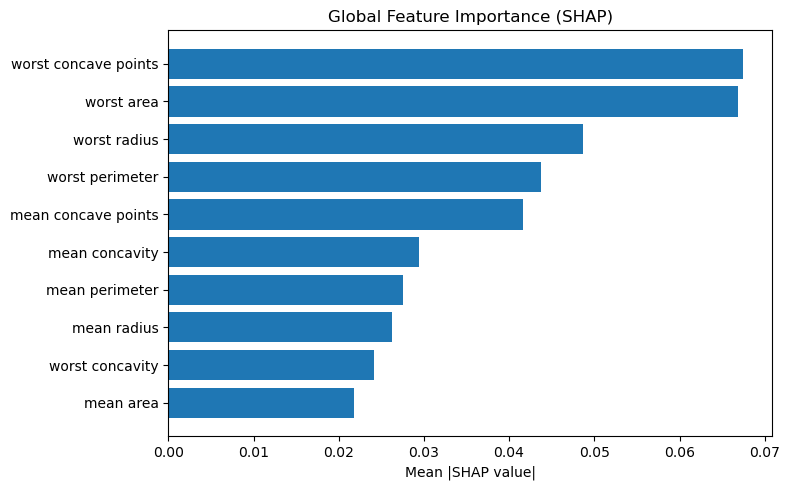

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(
    global_importance["feature"],
    global_importance["importance"]
)
plt.gca().invert_yaxis()
plt.title("Global Feature Importance (SHAP)")
plt.xlabel("Mean |SHAP value|")
plt.tight_layout()
plt.show()


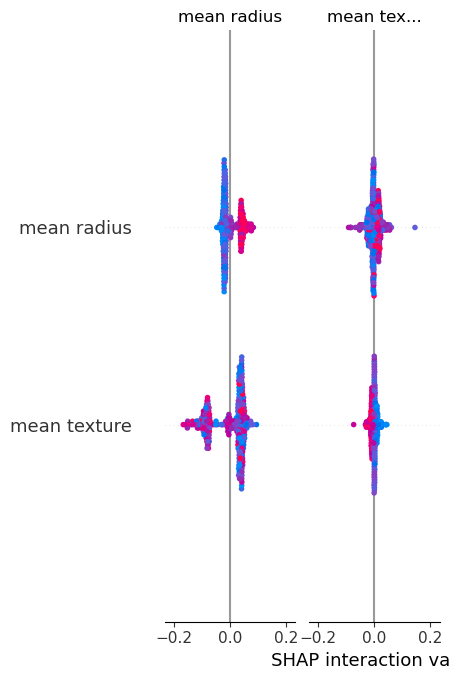

In [9]:
import shap
shap_values = explainer.explainer.shap_values(X_train)

if isinstance(shap_values, list):
    shap_values = shap_values[1]

shap.summary_plot(shap_values, X_train)


In [10]:
# Local explanation for one instance
local_explanation = explainer.explain_instance(sample_instance)

local_explanation.head(10)


,feature,shap_value
24,worst smoothness,0.002126
15,compactness error,0.001815
28,worst symmetry,0.000115
8,mean symmetry,-0.000280
14,smoothness error,-0.000482
4,mean smoothness,-0.000519
9,mean fractal dimension,-0.000542
19,fractal dimension error,-0.000703
18,symmetry error,-0.000950
17,concave points error,-0.001291


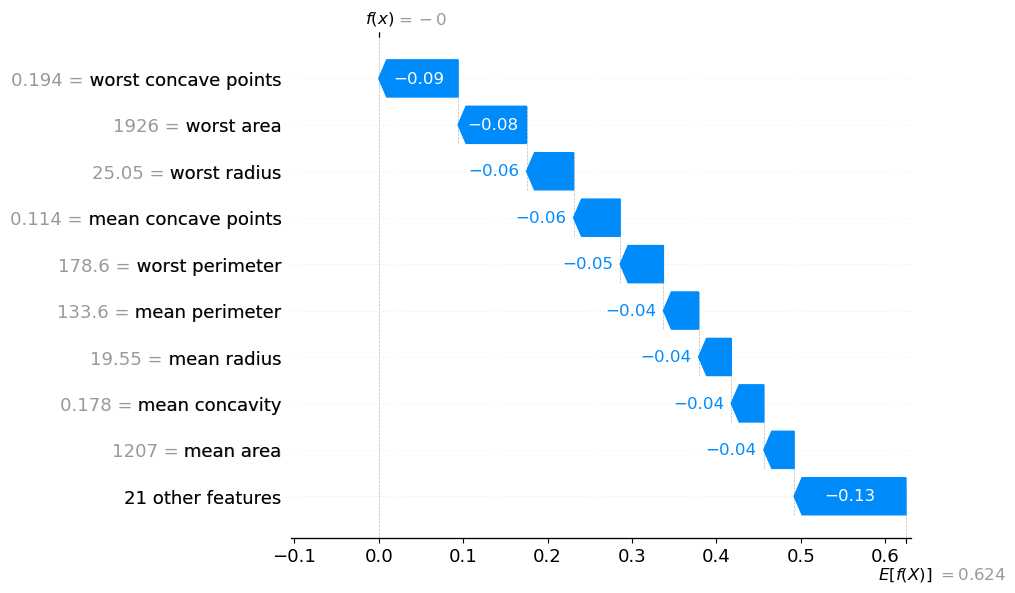

In [11]:
# Prepare instance as DataFrame
instance_df = pd.DataFrame([sample_instance], columns=X_train.columns)

# Get SHAP explanation using unified API
shap_exp = explainer.explainer(instance_df)

# For binary classification, select:
# first instance, positive class (index 1)
waterfall_exp = shap_exp[0, :, 1]

# Plot waterfall
shap.plots.waterfall(waterfall_exp)


In [12]:
print(explainer.explain_instance_text(sample_instance))


Top factors influencing the prediction:
- worst smoothness increased the risk
- compactness error increased the risk
- worst symmetry increased the risk
- mean symmetry decreased the risk
- smoothness error decreased the risk



In [13]:
counterfactual_instance = explainer.counterfactual(sample_instance)

if counterfactual_instance is not None:
    print("Counterfactual found!")
    display(pd.DataFrame({
        "Original": sample_instance,
        "Counterfactual": counterfactual_instance
    }))
else:
    print("No counterfactual found within limits.")


No counterfactual found within limits.


In [15]:
if counterfactual_instance is not None:
    changes = (counterfactual_instance - sample_instance).abs()
    changes = changes[changes > 0]

    print("Minimal changes to flip prediction:")
    print(changes.sort_values().head(5))
else:
    print("No counterfactual found — prediction is robust for this instance.")


No counterfactual found — prediction is robust for this instance.
